# COMP0188 Lab 2: Multi-Layer Perceptrons (MLPs)

In this lab we will cover multi-layer perceptrons in more detail. The lab is split into two sections.

First, we implement MLPs in pytorch, and explore different hyperparameters and design decisions (e.g. learning rates, optimizers, architecture) that can effect performance.

Second, we will implement and train an MLP from scratch, using numpy! This is a very useful exercise to help ensure you have a good understanding of the low-level details related to MLP neural networks and stochastic gradient descent.

Lets begin!

In [1]:
import wandb

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim

import os
from typing import Union, Callable, Tuple, List, Literal
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
torch.cuda.is_available()

False

# Load MNIST

The dataset we will be using today is MNIST. It is a datset of small images of handwritten numbers. The task is to take in the image and predict the number.

Lets download the data.

Note that since we are using an MLP, we must flatten the images from shape (Height, Width) to (Height * Width).

In [7]:
# Define a transform to normalize and flatten the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))  # This will flatten the image from (1,28,28) to (784,)
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets visualize the data.

images.shape: torch.Size([64, 784])
labels.shape: torch.Size([64])


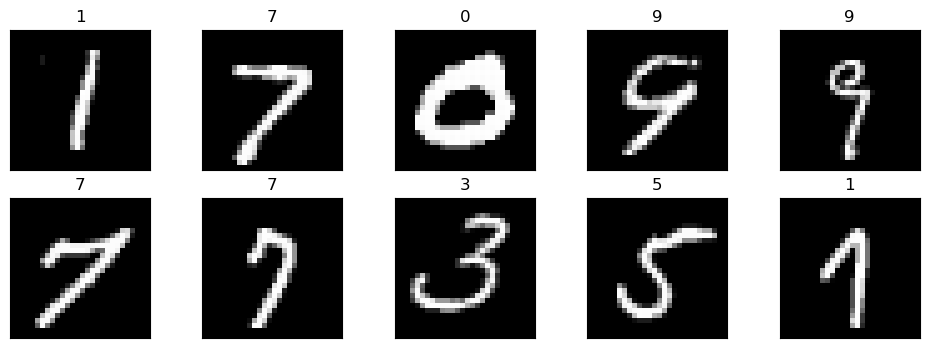

In [8]:
# Get one batch of images from the dataloader
sample_images, sample_labels = next(iter(train_loader))

print(f"images.shape: {sample_images.shape}")
print(f"labels.shape: {sample_labels.shape}")

# Note the dimension of the flatten images
mnist_in_dims = sample_images.shape[-1]

# Function to display an image
def imshow(img):
    # Unnormalize the image
    img = img * 0.5 + 0.5
    img = img.reshape(28, 28)  # reshape back to 28x28
    plt.imshow(img, cmap='gray')

# Display the first 10 images from the batch, and their corresponding label
fig = plt.figure(figsize=(12, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    imshow(sample_images[i])
    ax.set_title(str(sample_labels[i].item()))

plt.show()

#### MLP in Pytorch
Now we are at the first section of the lab. Here we implement MLPs in pytorch, and explore different hyperparameters and design decisions.

##### Training loop
First define the function for running a single epoch of training.

In [9]:
# Run a single epoch of training
def train_single_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    gpu: Literal[True, False],
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.modules.loss._Loss
) -> Tuple[List[float], List[torch.Tensor]]:

    model.train()  # Set model to training mode

    losses = []
    preds = []

    # TQDM progress bar for tracking the training loop
    range_gen = tqdm(
        enumerate(data_loader),
        total=len(data_loader),
        desc="Training Epoch"
    )

    # Loop through batches in the data loader
    for i, (X, y) in range_gen:

        # Move data to GPU if available
        if gpu:
            X = X.cuda()
            y = y.cuda()
        else:
            X = Variable(X)
            y = Variable(y)

        ### 🚧 Your code here (start) 🚧 ####
        # Reset the gradients in the optimizer to zero
        optimizer.zero_grad()

        # Compute the predictions of the model for the input data X
        output = model(X)

        # Compute the loss between the predicted output and the actual labels y
        train_loss  = criterion(output, y)

        # Calculate the gradients of the loss with respect to the model's parameters
        train_loss.backward()

        # Update the model's parameters based on the gradients
        optimizer.step()
        ### 🚧 Your code here (end) 🚧 ####

        # Log predictions and loss
        preds.append(output.detach().cpu())  # Detach and move to CPU to avoid memory issues
        losses.append(train_loss.item())  # Append the loss value

    return losses, preds

Next define the validation loop. Note, for simplicity, here we will use the MNIST test set as our validation set.

In [10]:
# Validate the model over the validation data
def validate(
    model:nn.Module,
    data_loader:torch.utils.data.DataLoader,
    gpu:Literal[True, False],
    criterion:torch.nn.modules.loss
  ) -> Tuple[List[torch.Tensor]]:

    model.eval()
    losses = []
    preds = []
    correct = 0
    total = 0
    with torch.no_grad():
        range_gen = tqdm(
            enumerate(data_loader),
        )

        for i, (X, y) in range_gen:

            if gpu:
                X = X.cuda()
                y = y.cuda()
            else:
                X = Variable(X)
                y = Variable(y)

            # Compute output
            output = model(X)

            # Calculate predictions
            _, predicted = torch.max(output.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Logs
            losses.append(criterion(output, y).item())
            preds.append(output)
    accuracy = 100 * correct / total
    return losses, accuracy

Now the training and validation functions can be combined to create a function that runs multiple epochs of training.

In [11]:
# Run the model training
def train(
    model:torch.nn,
    train_data_loader:torch.utils.data.DataLoader,
    val_data_loader:torch.utils.data.DataLoader,
    gpu:Literal[True, False],
    optimizer:torch.optim,
    criterion:torch.nn.modules.loss,
    epochs:int,
    scheduler:torch.optim.lr_scheduler=None,
    use_wandb:int=False
  ) -> Tuple[List[torch.Tensor]]:

    if gpu:
        model.cuda()

    # Prepare to track stats
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_val_accuracy = []

    # Training loop
    for epoch in range(1, epochs+1):

        # Train for a single epoch
        train_loss_val, _ =  train_single_epoch(
            model=model, data_loader=train_data_loader, gpu=gpu,
            optimizer=optimizer, criterion=criterion)
        # Record train stats
        mean_train_loss = np.mean(train_loss_val)
        epoch_train_loss.append(mean_train_loss)

        # Validate model
        val_loss_val, val_accuracy = validate(
            model=model, data_loader=val_data_loader, gpu=gpu,
            criterion=criterion)
        # Record validation stats
        mean_val_loss = np.mean(val_loss_val)
        epoch_val_loss.append(mean_val_loss)
        epoch_val_accuracy.append(val_accuracy)

        print(f'Epoch: {epoch}/{epochs} | Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%')

        if use_wandb:
          wandb.log({"train_loss": mean_train_loss, "val_loss": mean_val_loss})

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy

#### Train a basic MLP

In week1 we introduced a linear regression model constructed in pytorch by inheriting the nn.Module class and creating a linear layer with nn.Linear(). In this section we construct the MLP model using more components.
* nn.ReLU() - this defines a relu non-linear activation function
* nn.ModuleList() - this the principal way to chain together a number of pytorch Modules using an API similar to python's native 'List' class, which makes it easy to add layers in a flexible way, and we can iterate through the list of layers in the forward method.

Here is an example to show the utility of above functions
* we build a simple 2-layer Multi-Layer Perceptron (MLP) using PyTorch and use nn.ModuleList to create multi layers of the NN model

In [12]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        # Using nn.ModuleList to store layers
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),  # First layer: input to hidden
            nn.ReLU(),                          # Activation function
            nn.Linear(hidden_size, output_size)  # Second layer: hidden to output
        ])

    # Define the forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage
input_size = 10  # Number of input features
hidden_size = 5  # Number of neurons in the hidden layer
output_size = 2  # Number of output classes

# Initialize the model
model = SimpleMLP(input_size, hidden_size, output_size)

# Create a sample input tensor (batch_size, input_size)
input_data = torch.randn(3, input_size)  # Batch of 3 samples

# Perform a forward pass
output = model(input_data)

# Print the output
print("Model output:", output)

Model output: tensor([[-0.6466, -0.7325],
        [-0.5742, -0.7484],
        [-0.2261, -0.0701]], grad_fn=<AddmmBackward0>)


* Besides defining layers manually, for multi-layer neural networks we can also add them more flexibly in the form of lists.

In [13]:
# Define an MLP model using nn.ModuleList
class FlexibleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=nn.ReLU):
        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()  # Initialize an empty ModuleList

        # Append first layer (input to first hidden layer)
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Append intermediate layers (hidden layers)
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Append the final layer (last hidden layer to output)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Store activation function, we'll apply it between the layers
        self.activation = activation_fn()

    # Define the forward pass
    def forward(self, x):
        # Pass input through all layers except the last, applying activation after each
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))  # Apply linear layer followed by activation
        # Apply the final layer without activation
        x = self.layers[-1](x)
        return x

# Example usage
input_size = 10             # Number of input features
hidden_sizes = [20, 15]     # Sizes of hidden layers
output_size = 5             # Number of output classes

# Initialize the model
model = FlexibleMLP(input_size, hidden_sizes, output_size, activation_fn=nn.ReLU)

# Create a sample input tensor (batch_size, input_size)
input_data = torch.randn(3, input_size)  # Batch of 3 samples

# Perform a forward pass
output = model(input_data)

# Print the output
print("Model output:", output)

Model output: tensor([[-0.0379, -0.0035,  0.2652,  0.1200, -0.2457],
        [-0.0916, -0.0833,  0.0615, -0.0039, -0.1999],
        [-0.0569, -0.0112,  0.0385,  0.0339, -0.2596]],
       grad_fn=<AddmmBackward0>)


Let's start creating our own MLP model.

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        ## 🚧 Your code here (start) 🚧 ####
        self.layers = nn.ModuleList()  # Initialize an empty ModuleList
        # Define the layers using ModuleList
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        # Append intermediate layers (hidden layers)
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        # Append the final layer (last hidden layer to output)
        self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        ## 🚧 Your code here (end) 🚧 ####

    def forward(self, x):
        ## Forward pass through the network
          # Pass data through each layer sequentially
        for layer in self.layers:
            x = layer(x)
        return x
        # IMPORTANT: since we use nn.CrossEntropyLoss() as our loss function,
        # we need DON'T an activation on the final model output.

In [15]:
## 🚧 Your code here (start) 🚧 ####

# MNIST images are 28x28, so the input dimension is 28 * 28 = 784
input_dim = 784

# Define the hidden layer size (you can adjust this)
hidden_dim = [64,64]

# There are 10 classes in MNIST (numbers 0-9)
num_classes = 10
## 🚧 Your code here (end) 🚧 ####

# Initialize MLP
mlp_model = MLP(input_dim, hidden_dim, num_classes)
print(mlp_model)

#print("Model output shape:", mlp_model(sample_images).shape)
#print(mlp_model.parameters())

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


Expect one epoch of training to take around 20-30 seconds on a CPU.

In [16]:
# Set the appropriate loss function and optimizer
## 🚧 Your code here (start) 🚧 ####
# Suitable for multi-class classification
criterion = nn.CrossEntropyLoss()
# Adam optimizer with a learning rate of 0.001
mlp_model = MLP(input_dim, hidden_dim, num_classes)  # Ensure the model is initialized
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

epochs = 5
## 🚧 Your code here (end) 🚧 ####
criterion = nn.CrossEntropyLoss()
# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

epochs = 5

# Run training
epoch_train_loss, epoch_val_loss, epoch_val_accuracy = train(
    model=mlp_model,
    train_data_loader=train_loader,
    val_data_loader=test_loader,
    gpu=False,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
)

Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 107.95it/s]
157it [00:01, 117.85it/s]


Epoch: 1/5 | Train Loss: 0.4220 | Val Loss: 0.3458 | Val Accuracy: 89.90%


Training Epoch: 100%|██████████| 938/938 [00:09<00:00, 102.88it/s]
157it [00:01, 109.35it/s]


Epoch: 2/5 | Train Loss: 0.3364 | Val Loss: 0.3304 | Val Accuracy: 90.70%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 104.28it/s]
157it [00:01, 110.27it/s]


Epoch: 3/5 | Train Loss: 0.3211 | Val Loss: 0.3082 | Val Accuracy: 91.52%


Training Epoch: 100%|██████████| 938/938 [00:09<00:00, 102.90it/s]
157it [00:01, 116.86it/s]


Epoch: 4/5 | Train Loss: 0.3154 | Val Loss: 0.2959 | Val Accuracy: 91.39%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 107.18it/s]
157it [00:01, 112.46it/s]

Epoch: 5/5 | Train Loss: 0.3071 | Val Loss: 0.2997 | Val Accuracy: 91.36%


Now we plot the results.

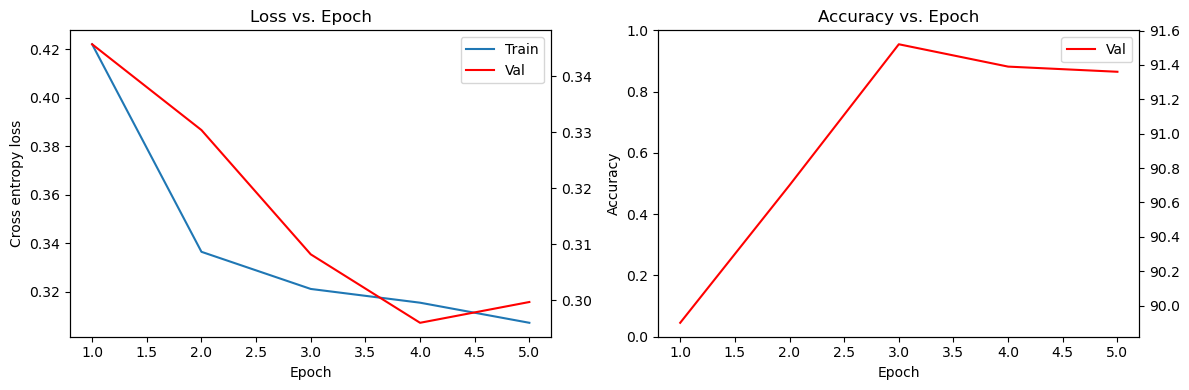

In [17]:
# Creating 1x2 subplots
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,4))

# Plotting loss on the left side
ax2 = ax1.twinx()
lns1 = ax1.plot(range(1, epochs+1), epoch_train_loss, label="Train")
lns2 = ax2.plot(range(1, epochs+1), epoch_val_loss, label="Val", c="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross entropy loss")
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_title("Loss vs. Epoch")

# Plotting accuracy on the right side
ax4 = ax3.twinx()
lns3 = ax4.plot(range(1, epochs+1), epoch_val_accuracy, label="Val", c="red")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Accuracy")
lns = lns3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.set_title("Accuracy vs. Epoch")

plt.tight_layout()
plt.show()


Now lets visualize some predictions!

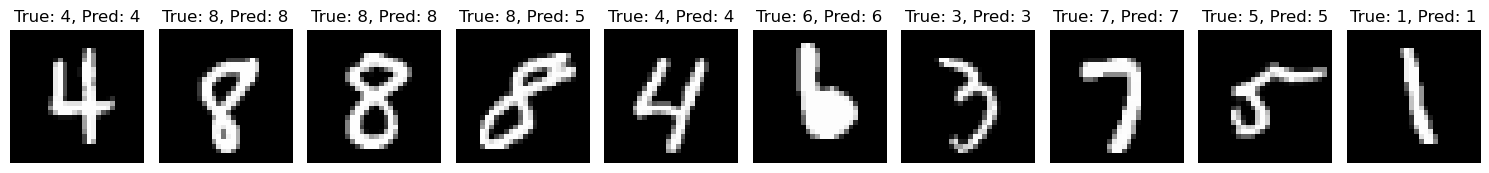

In [18]:
def visualize_predictions(model, data_loader, gpu, num_images=10):
    model.eval()  # Set model to evaluation mode

    # Sample a batch of data from the data loader
    images, labels = next(iter(data_loader))

    if gpu:
        images = images.cuda()
        labels = labels.cuda()

    ## 🚧 Your code here (start) 🚧 ####
    # Get model predictions
    outputs = model(images)# Forward pass through the model
    # Get the index of the highest logit
    _, predicted = torch.max(outputs, 1)
    
    ## 🚧 Your code here (end) 🚧 ####

    # Move to CPU for visualization
    images = images.cpu().numpy().reshape(-1, 28, 28)  # Reshape flattened images
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Plot images and predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')  # Plot the image
        ax.set_title(f"True: {labels[i]}, Pred: {predicted[i]}")  # Show true and predicted labels
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming test_loader is defined
visualize_predictions(mlp_model, test_loader, gpu=False)

## MLP design decisions & hyperparameters

Now lets explore some different hyperparameters that can be tuned to improve performance. We will look at:

- Learning rate
- Optimizers
- Architecture

But you may also consider weight initializations, Activations (e.g. ReLU, sigmoid), regularisation techniques (such as dropout), and early stopping.

For each, can you produce a plot that compares across different hyperparameters, to visualize which works best? (W&B may be useful here)

First, we should create a more customized model using a similar approach to the FlexibleMLP definition presented previously

In [19]:
class MLP_Customizable(nn.Module):

    def __init__(
        self,
        input_dim:int,
        hidden_size:List[int],
        n_classes:int,
        actvtns:List[Union[None, nn.Module]],
        seed=1
    ) -> None:

        super().__init__()
        torch.manual_seed(seed)
        assert len(actvtns) == len(hidden_size)
        self.layers = nn.ModuleList()

        all_layer_size = [*hidden_size, n_classes]
        _layer = nn.Linear(
                    in_features=input_dim,
                    out_features=all_layer_size[0]
        )
        self.__init_linear(_layer)
        self.layers.append(_layer)
        if len(hidden_size) > 0:
            for i in np.arange(1, len(all_layer_size)):
                self.layers.append(actvtns[i-1])
                _layer = nn.Linear(
                        in_features=all_layer_size[i-1],
                        out_features=all_layer_size[i]
                )
                self.__init_linear(_layer)
                self.layers.append(_layer)

    def __init_linear(self, layer):
        # Note, it is important to correctly initialize the weights of the model!
        nn.init.xavier_normal_(layer.weight)
        nn.init.zeros_(layer.bias)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

##### Learning Rates

Here, you can explore the effect of the learning rate. Note, learning rate hyperparameter searchers are usually done on a log scale over several orders of magnitude (e.g., 0.1, 0.3, 0.01, 0.003).

In [22]:
# Start with these learning rates
learning_rates = [1e-1, 1e-2, 1e-3]
epochs = 5

all_train_losses = []
all_val_losses = []

# Train a model for each learning rate
for lr in learning_rates:

    # if use_wandb:
    #   wandb.init(project='diabetes_prediction', config=config)

    mlp = MLP_Customizable(
        input_dim=mnist_in_dims,
        hidden_size=[64],  # 64 hidden units
        actvtns=[nn.ReLU()],  # ReLU activation for hidden layer
        n_classes=10,  # 10 output classes
    )

    ## 🚧 Your code here (start) 🚧 ####
    # You can experiment with different optimizers For example, Adam, SGD, or RMSprop.
    optimizer = optim.Adam(mlp.parameters(), lr=lr)  # Using Adam optimizer with variable learning rate
    ## 🚧 Your code here (end) 🚧 ####
    
    # Loss function: CrossEntropyLoss is suitable for multi-class classification problems
    criterion = nn.CrossEntropyLoss()

    # Train the model and save the loss values
    epoch_train_loss, epoch_val_loss, epoch_val_accuracy = train(
        model=mlp,
        train_data_loader=train_loader,
        val_data_loader=test_loader,
        gpu=False,  # Set to True if using GPU
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
    )

    # Append the losses for tracking and plotting later
    all_train_losses.append(epoch_train_loss)
    all_val_losses.append(epoch_val_loss)

# Optionally, you can plot the training and validation losses after training for all learning rates

Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 110.68it/s]
157it [00:01, 114.37it/s]


Epoch: 1/5 | Train Loss: 2.7418 | Val Loss: 2.3144 | Val Accuracy: 10.32%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 106.43it/s]
157it [00:01, 119.24it/s]


Epoch: 2/5 | Train Loss: 2.3094 | Val Loss: 2.3122 | Val Accuracy: 10.32%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 105.44it/s]
157it [00:01, 123.54it/s]


Epoch: 3/5 | Train Loss: 2.3100 | Val Loss: 2.3040 | Val Accuracy: 10.09%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 106.01it/s]
157it [00:01, 117.30it/s]


Epoch: 4/5 | Train Loss: 2.3097 | Val Loss: 2.3073 | Val Accuracy: 10.09%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 105.02it/s]
157it [00:01, 128.79it/s]


Epoch: 5/5 | Train Loss: 2.3101 | Val Loss: 2.3078 | Val Accuracy: 11.35%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 111.96it/s]
157it [00:01, 125.44it/s]


Epoch: 1/5 | Train Loss: 0.5494 | Val Loss: 0.3507 | Val Accuracy: 89.36%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 104.56it/s]
157it [00:01, 121.01it/s]


Epoch: 2/5 | Train Loss: 0.3931 | Val Loss: 0.3496 | Val Accuracy: 89.94%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 107.95it/s]
157it [00:01, 122.14it/s]


Epoch: 3/5 | Train Loss: 0.3769 | Val Loss: 0.3553 | Val Accuracy: 89.40%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 108.73it/s]
157it [00:01, 125.44it/s]


Epoch: 4/5 | Train Loss: 0.3653 | Val Loss: 0.3275 | Val Accuracy: 90.18%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 105.67it/s]
157it [00:01, 122.09it/s]


Epoch: 5/5 | Train Loss: 0.3559 | Val Loss: 0.3411 | Val Accuracy: 89.92%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 106.88it/s]
157it [00:01, 118.19it/s]


Epoch: 1/5 | Train Loss: 0.3838 | Val Loss: 0.2358 | Val Accuracy: 92.86%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 108.19it/s]
157it [00:01, 123.34it/s]


Epoch: 2/5 | Train Loss: 0.2149 | Val Loss: 0.1928 | Val Accuracy: 94.05%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 108.94it/s]
157it [00:01, 121.99it/s]


Epoch: 3/5 | Train Loss: 0.1729 | Val Loss: 0.1844 | Val Accuracy: 94.34%


Training Epoch: 100%|██████████| 938/938 [00:08<00:00, 107.04it/s]
157it [00:01, 124.87it/s]


Epoch: 4/5 | Train Loss: 0.1488 | Val Loss: 0.1770 | Val Accuracy: 94.65%


Training Epoch: 100%|██████████| 938/938 [00:09<00:00, 103.96it/s]
157it [00:01, 125.45it/s]

Epoch: 5/5 | Train Loss: 0.1322 | Val Loss: 0.1337 | Val Accuracy: 96.02%


* High LR: Quick initial progress but can lead to instability or divergence.
* Moderate LR: Balanced learning, typically yielding better accuracy and stable convergence.
* Low LR: Very stable but slow learning, useful for fine-tuning or when nearing convergence.

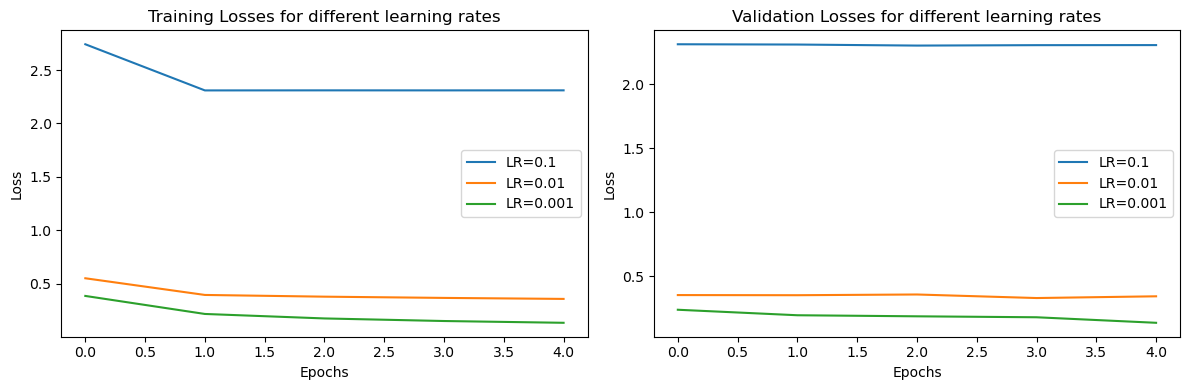

In [23]:
## Plot results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Plot train losses for each learning rate on the left subplot
for i, lr in enumerate(learning_rates):
    ax1.plot(all_train_losses[i], label=f"LR={lr}")

ax1.set_title('Training Losses for different learning rates')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation losses for each learning rate on the right subplot
for i, lr in enumerate(learning_rates):
    ax2.plot(all_val_losses[i], label=f"LR={lr}")

ax2.set_title('Validation Losses for different learning rates')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

Which learning rates worked best? Why? How did they behave in the early and later stages of training?

Try using a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) to see if you can improve upon just using a fixed learning rate. Does this help? If so, what insights does it give?

A learning rate scheduler modifies the learning rate during the training process according to a predefined schedule. This can help the model avoid getting stuck in local minima and achieve better performance, particularly as training progresses and we want finer adjustments to the model weights.

In [24]:
# Define learning rates and number of epochs
learning_rates = [1e-1, 1e-2, 1e-3]
epochs = 5

# Define placeholder lists for losses (with and without scheduler)
all_train_losses_no_sched = []
all_val_losses_no_sched = []

all_train_losses_sched = []
all_val_losses_sched = []


# Define a function to simulate training
def train(model, train_data_loader, val_data_loader, gpu, optimizer, criterion, scheduler=None, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_data_loader:
            if gpu:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_data_loader))

        # Validation loop (not updating the model, only checking the loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_data_loader:
                if gpu:
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data_loader))

        if scheduler:
            scheduler.step()

    return train_losses, val_losses

# Train models without scheduler
for lr in learning_rates:
    mlp = MLP_Customizable(input_dim=28*28, hidden_size=[64], n_classes=10, actvtns=[nn.ReLU()])
    optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = train(
        model=mlp,
        train_data_loader=train_loader,
        val_data_loader=test_loader,
        gpu=False,  # Set to True if using GPU
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs
    )

    all_train_losses_no_sched.append(train_losses)
    all_val_losses_no_sched.append(val_losses)

# Train models with scheduler
for lr in learning_rates:
    mlp = MLP_Customizable(input_dim=28*28, hidden_size=[64], n_classes=10, actvtns=[nn.ReLU()])
    optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Learning rate scheduler
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = train(
        model=mlp,
        train_data_loader=train_loader,
        val_data_loader=test_loader,
        gpu=False,  # Set to True if using GPU
        optimizer=optimizer,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs
    )

    all_train_losses_sched.append(train_losses)
    all_val_losses_sched.append(val_losses)



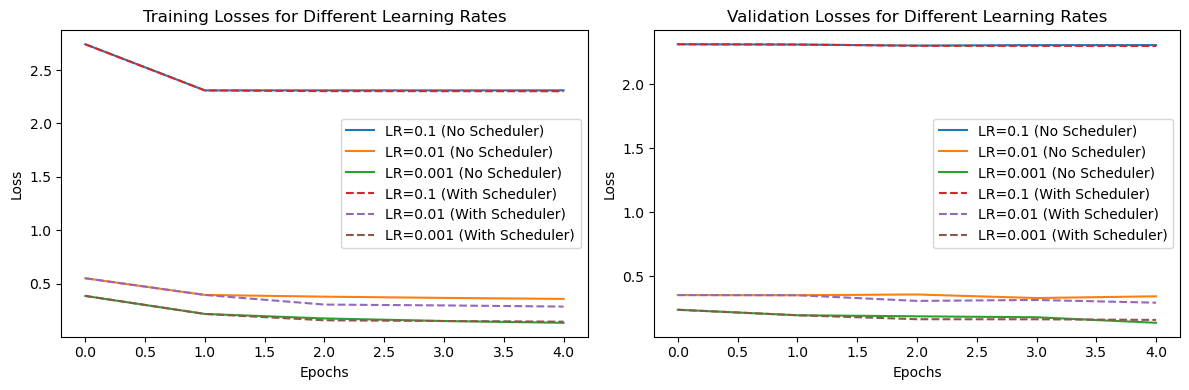

In [25]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Plot train losses for each learning rate (without scheduler)
for i, lr in enumerate(learning_rates):
    ax1.plot(all_train_losses_no_sched[i], label=f"LR={lr} (No Scheduler)")

# Plot train losses for each learning rate (with scheduler)
for i, lr in enumerate(learning_rates):
    ax1.plot(all_train_losses_sched[i], '--', label=f"LR={lr} (With Scheduler)")

ax1.set_title('Training Losses for Different Learning Rates')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation losses for each learning rate (without scheduler)
for i, lr in enumerate(learning_rates):
    ax2.plot(all_val_losses_no_sched[i], label=f"LR={lr} (No Scheduler)")

# Plot validation losses for each learning rate (with scheduler)
for i, lr in enumerate(learning_rates):
    ax2.plot(all_val_losses_sched[i], '--', label=f"LR={lr} (With Scheduler)")

ax2.set_title('Validation Losses for Different Learning Rates')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# 🚨 Implement MLP training from scratch in Numpy 🚨

#### Prepare dataset

First we need to convert the dataset to numpy.

In [ ]:
# Convert PyTorch tensors to NumPy arrays (expect this to take 30-60 seconds)

# Extract all the training data
train_images = [image for image, label in trainset]
train_labels = [label for image, label in trainset]

# Convert to NumPy arrays
train_images_np = torch.stack(train_images).numpy()
train_labels_np = torch.tensor(train_labels).numpy()

# Extract all the test data
test_images = [image for image, label in testset]
test_labels = [label for image, label in testset]

# Convert to NumPy arrays
test_images_np = torch.stack(test_images).numpy()
test_labels_np = torch.tensor(test_labels).numpy()

print("Training images shape:", train_images_np.shape)
print("Training labels shape:", train_labels_np.shape)
print("Test images shape:", test_images_np.shape)
print("Test labels shape:", test_labels_np.shape)

mnist_in_dims = train_images_np.shape[-1]

We can more easily calculate our loss if the labels are one-hot encoded, so lets do this:

In [ ]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = 10  # For MNIST, we have 10 classes (0 through 9)

# Convert the labels to one-hot encoding
train_labels_onehot_np = one_hot_encode(train_labels_np, num_classes)
test_labels_onehot_np = one_hot_encode(test_labels_np, num_classes)

# Print the new shapes
print("One-hot training labels shape:", train_labels_onehot_np.shape)
print("One-hot test labels shape:", test_labels_onehot_np.shape)

Note some notation we use:
- S = size of dataset (S-tr = training data size, S_te = test data size)
- H = height (in pixels) of image
- W = width (in pixels) of image
- C = the number of classes (always 10 for MNIST)
- N = batch size
- D_in = dimension of the input to the network
- D_hid = dimension of the hidden layer of the network
- D_out = dimension of the mlp output (i.e. the number of MNSIT classes)

##### Stochastic Gradient Descent

Here we will define some of the higher level framework code to run the SGD training loop.

In [ ]:
def plot_train_progress(loss_l, acc_train_l, acc_test_l, iters_per_point, total_iters=None):

    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
    assert len(loss_l) == len(acc_train_l) == len(acc_test_l)
    x_points = range(0, len(loss_l)*iters_per_point, iters_per_point)

    axes[0].plot(x_points, loss_l, color="black", label="Training loss", linewidth=5)
    axes[0].set_title("Training loss", fontsize=10, y=1.022)
    axes[0].yaxis.grid(True, zorder=0)
    axes[0].set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes[0].set_xlim([0,total_iters])
    axes[0].set_ylim([0,None])
    axes[0].legend(loc='upper right')

    axes[1].set_title("Accuracy", fontsize=10, y=1.022)
    axes[1].plot(x_points, acc_train_l, color="blue", label="Train", linewidth=5)
    axes[1].plot(x_points, acc_test_l, color="red", label="Test", linewidth=5)
    axes[1].yaxis.grid(True, zorder=0)
    axes[1].set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes[1].set_xlim([0,total_iters])
    axes[1].set_ylim([0,100])
    axes[1].legend(loc='lower right')

    plt.show()


def get_random_batch(train_imgs, train_lbls, batch_size, rng):
    # train_imgs: Images for training. Numpy array of shape [S, H*W]
    # train_lbls: Labels of the training images. Numpy array [S, C]
    # batch_size: integer. Size that the batch should have (N).

    ####### TODO: Sample a random batch of images for training. Fill in the blanks #########
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=batch_size, dtype='int32')
    ##############################################################################################

    train_imgs_batch = train_imgs[indices]
    train_lbls_batch = train_lbls[indices]
    return [train_imgs_batch, train_lbls_batch]

def gradient_descent(net, loss_func, update_params_func, rng,
                     train_imgs, train_lbls, test_imgs, test_lbls,
                     batch_size, learning_rate, total_iters, iters_per_test=-1 ):
    # net: Instance of a model. See classes: MLP_Numpy, MLP_Torch, MLP_Torch_Autograd, CNN_Torch_Autograd.
    # loss_func: Function that computes the loss. See functions: cross_entropy_numpy/torch.
    # update_params_func: Function performing SGD parameter updates. See: grad_descent_update_numpy/torch/autograd
    # rng: numpy random number generator
    # train_imgs: The training images. Numpy array, shape [S_tr, H*W]
    # test_imgs: Save as above, for testing images. [S_te, H*W]
    # train_lbls: One hot representation of labels corresponding to train_imgs. Numpy array, shape [S_tr, C]
    # test_lbls: As above, but for testing data. [S_te, C]
    # batch_size: Size N of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many iterations in total to perform.
    # iters_per_test: Integer. Every that many iterations the model predicts the test data and accuracy is reported.
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}

    for t in range(total_iters):
        # Sample batch for this SGD iteration
        train_imgs_batch, train_lbls_batch = get_random_batch(train_imgs, train_lbls, batch_size, rng)

        # Forward pass
        y_pred = net.forward_pass(train_imgs_batch)

        # Compute loss: Cross Entropy
        y_real = train_lbls_batch
        loss = loss_func(y_pred, y_real)

        # Backwards pass. Compute gradients.
        grads = net.backward_pass(loss, y_real)

        # Update weights with gradient descent
        update_params_func(net.params, grads, learning_rate=learning_rate)


        # ==== Report training loss and accuracy ======
        # y_pred and loss can be either np.array, or torch.tensor (see later). If tensor, make it np.array.
        y_pred_numpy = y_pred if type(y_pred) is np.ndarray else y_pred.detach().numpy()
        y_pred_lbls = np.argmax(y_pred_numpy, axis=1) # y_pred is soft/probability. Make it a hard one-hot label.
        y_real_lbls = np.argmax(y_real, axis=1)

        acc_train = np.mean(y_pred_lbls == y_real_lbls) * 100. # percentage

        loss_numpy = loss if type(loss) is type(float) else loss.item()
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss), "\t Accuracy: {0:.2f}".format(acc_train))

        # =============== Every few iterations, predict the testing-database ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            y_pred_test = net.forward_pass(test_imgs)
            # ==== Report test accuracy ======
            y_pred_test_numpy = y_pred_test if type(y_pred_test) is np.ndarray else y_pred_test.detach().numpy()
            y_pred_lbls_test = np.argmax(y_pred_test_numpy, axis=1)
            y_real_lbls_test = np.argmax(test_lbls, axis=1)
            acc_test = np.mean(y_pred_lbls_test == y_real_lbls_test) * 100.
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))

            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss_numpy)
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)

##### Classification with Multi-Layer Perceptron (MLP) in Numpy

Now we implement the low level details of the MLP and the forward and backward pass!

The network will have a single hidden layer, taking the form:

`x -> fully connected -> relu -> fully connected -> softmax`
(Note, in the code we will use 'h' to denote the hidden layer activations, rather than the 'z' used in the image above)

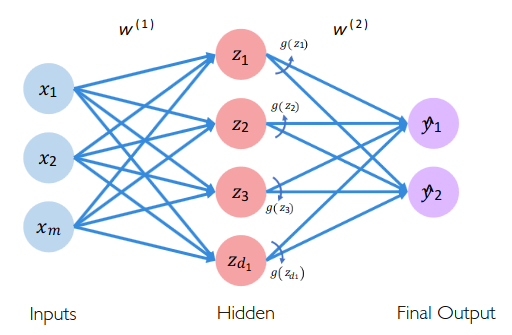

In [ ]:
class MLP_Numpy():
    def __init__(self, rng, in_dims, hidden_size=1000, n_classes=10):
        # Construct and initialize network parameters
        D_in = in_dims # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid = hidden_size # Dimension of Hidden layer.
        D_out = n_classes # Dimension of Output layer. Number of classes

        ###### 🚧 TODO: Initialize parameters of MLP by sampling from N(0,0.01). Fill the blanks 🚧 #####
        # Also see forward_pass(), to see how they are used. It will help you infer correct shapes.
        w1 = rng.normal(loc=, scale=, size=) # D_in+1 because we add bias in forward pass
        w2 =  # Params of 2nd layer
        self.params = [w1, w2]
        #################################################################################

    def forward_pass(self, batch_imgs):
        # This function applies the model to the input. It essentially defines the model's architecture.
        # Input: batch_imgs: Input batch. Numpy.array of [N=number of samples, H=height, W=width] floats.
        # Returns: y_pred: array of [N, D_out] floats. y_pred[i] contains class posterior (probs) for sample i.
        [w1, w2] = self.params

        unary_feature_for_bias = np.ones(shape=(batch_imgs.shape[0], 1)) # [N, 1] column vector.
        x = np.concatenate((batch_imgs, unary_feature_for_bias), axis=1) # Extra feature=1 for bias.

        ################ 🚧 TODO: Fill the blanks 🚧 ##############################################
        # Build network of form: x -> fully connected -> relu -> fully connected -> softmax
        # Hidden layer
        h1 =  # shape: [Batch_size, D_hid]
        h1_relu =
        # Fully-connected classifier.
        h1_ext =  # Extend for bias. Output shape: [N, D_hid+1]
        h2 =
        logits = h2
        ############################################################################################

        # Softmax activation function.
        exp_logits = np.exp(logits)
        y_pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        # sum with Keepdims=True returns [N,1] array. It would be [N] if keepdims=False.
        # Numpy broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).

        # Store activations. Will be needed for backprop.
        self.__activations = [x, h1, h1_relu, h1_ext, h2, y_pred]

        return y_pred


    def backward_pass(self, loss, y_real): # NOTE: Loss value is not directly needed for computing grads in closed form.
        # Performs back-propagation in closed form.
        # Computes the gradient of the loss with respect to trainable parameters.
        # y_real: Array [N, D_out]. y_real[i] is one-hot representation of real training label for i-th sample.
        # returns grads: list of arrays, one for each trainable parameter.

        [x, h1, h1_relu, h1_ext, h2, y_pred] = self.__activations
        [w1, w2] = self.params

        N = y_pred.shape[0]
        D_out = y_pred.shape[1]

        # Derivative of cross entropy wrt input to softmax (straight, without intermediate computes)
        # Difficult derivation. Nice explanation at: https://deepnotes.io/softmax-crossentropy
        grad_logits = (y_pred - y_real) / N

        ##### 🚧 TODO: Fill in the blanks (to complete the back-prop for the 2-layers MLP 🚧 ###########
        grad_w2 =  # shape: [D_hid+1, D_out]. So it's [D_hid+1, N] dot [N, D_out]
        grad_h1_ext =  # shape: [N, D_hid+1]
        grad_h1_relu =  # Drop the extra feature dimension for the bias [N, D_hid]
        grad_h1 =  # Derivatives of activation functions.
        grad_h1[h1 < 0] =  # Derivatives of activation functions.
        grad_w1 =  # Shape [D_in+1, D_hid]
        ###############################################################################################

        # Elements of below list must be in same order as in self.params.
        # Each of the subarrays has the same shape as that of corresponding trainable parameter in self.params.
        grads = [grad_w1, grad_w2]
        return grads


def cross_entropy_numpy(y_pred, y_real, eps=1e-7):
    # Cross entropy
    # y_pred: Predicted class-posterior probabilities, returned by forward_pass. Matrix of shape [N, D_out]
    # y_real: One-hot representation of real training labels. Same shape as y_pred.

    ################# 🚧 TODO: Complete the calculation of cross-entropy for each sample 🚧 ################
    x_entr_per_sample =  # Sum over classes, axis=1
    ##################################################################################################

    loss = np.mean(x_entr_per_sample, axis=0) # Expectation of loss: Mean over samples (axis=0).
    return loss


def grad_descent_update_numpy(params, grads, learning_rate):
    # params: list of trainable parameters, created in initializer of the model.
    # grads: list of gradients, returned by backward pass of model. grads[i] corresponds to params[i]
    # learning_rate: a float.
    assert len(params)==len(grads)
    for i in range(len(params)):
        ##### 🚧 TODO: Perform the updates of the parameters by filling the blanks 🚧 ###########
        params[i] =
        ##########################################################################################

# Create the network
SEED = 42
rng = np.random.RandomState(seed=SEED) # Random number generator
net = MLP_Numpy(rng=rng, in_dims=mnist_in_dims)
# Start training
gradient_descent(net,
                 cross_entropy_numpy, # We are using the Numpy version we wrote above.
                 grad_descent_update_numpy, # We are using the Numpy version we wrote above.
                 rng,
                 train_images_np,
                 train_labels_onehot_np,
                 test_images_np,
                 test_labels_onehot_np,
                 batch_size=40,
                 learning_rate=1e-2,
                 total_iters=400,
                 iters_per_test=10)